## Using Enron Financial and Email data to Identify Fraud by Machine Learning 


Yang Wang          Merry Christmas! 

12.23.2016     


### 1.Project Description
Enron group scandal is the largest corporate fraud in American history. After a widespread Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. In this project, I investigate a publized Enron data set including both finical and Email record about 150 employees at Enron group. Several board members and management tiers involved in illegal business fraud were eventually charged. Some of these people were found guilty and sent to the jail. Some of people were settled out side of court. Those main characters entangled with fraud are people of interest, also tagged with 'poi' in the data set. The scheme of this project is to develop predcitve models on identification of people of interest by incorprating the financial and email communication information of employees. Machine Learning techniques are suitable for this supervised learning problem due to its powerful capability to make prediction by learning existed information. The goal of final model is to have a power of more than 0.3 on both recall and precision metrics. First, I investigate the data set and perform explortary data analysis to detect possible outliers and as a first attempt to feature selection. Then, I narrow down all the features with less missing values into 5 features by using  [SelectKbest](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) algorithm and Decision Tree. After that, I implement Naive Bayes, Decision Tree, Knearest Neighbours, and Support Vector Machine algorithms and tune  corresponding hyper-parameters with [GridSearch](http://scikit-learn.org/stable/modules/grid_search.html). Through the end of model selection and validation, I finalize the Decision Tress model with a precision of 0.59 and a recall of 0.50. 


In [202]:
import numpy as np
import pickle
import sys
import numpy as np
import pandas as pd
from feature_format import featureFormat, targetFeatureSplit
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  
sys.path.append("../tools/")
# import data
data_dict = pickle.load( open("final_project_dataset.pkl", "r") )
Enron_data = pd.DataFrame(data_dict).transpose()
sys.path.append("../tools/")

u'C:\\Users\\lavender\\Desktop\\Udacity_Github\\Data Analyst Nanodegree\\P5 Identify Fraud from Enron Email\\final_project'

In [254]:
# examine number of sample and features in the dataset
e = Enron_data
all_feature_list = e.columns
financial_features = ['salary', 'deferral_payments', 'total_payments',
                      'loan_advances', 'bonus', 'restricted_stock_deferred',
                      'deferred_income', 'total_stock_value', 'expenses',
                      'exercised_stock_options', 'other', 'long_term_incentive',
                      'restricted_stock', 'director_fees']
email_features =  ['to_messages', 'email_address', 'from_poi_to_this_person',
                    'from_messages', 'from_this_person_to_poi',
                    'shared_receipt_with_poi']
print "total number of sample: ", len(e)
print "total feature number: %d\n%r\n " %(len(all_feature_list), all_feature_list)
print "financial features number: %d\n%r\n" %(len(financial_features), financial_features)
print "email features number: %d\n%r\n" %(len(email_features), email_features)

total number of sample:  146
total feature number: 21
Index([u'bonus', u'deferral_payments', u'deferred_income', u'director_fees',
       u'email_address', u'exercised_stock_options', u'expenses',
       u'from_messages', u'from_poi_to_this_person',
       u'from_this_person_to_poi', u'loan_advances', u'long_term_incentive',
       u'other', u'poi', u'restricted_stock', u'restricted_stock_deferred',
       u'salary', u'shared_receipt_with_poi', u'to_messages',
       u'total_payments', u'total_stock_value'],
      dtype='object')
 
financial features number: 14
['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']

email features number: 6
['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']



### 2. Outlier detection
Due to the small size of data set, undiscovered outliers would severely jepordize the power of perdictive model. So it is imperative to do data cleaning before feature selection. In this step, I use explortary data analysis with various plots to detect obvious outliers. By scatterplot of salary vs bonus, there is a orange point far away from the other points. After data wrangling, I see it is the entry 'TOTAL' which is the total amount of salary. So this can be taken away for sure.

After using violinplot(http://seaborn.pydata.org/generated/seaborn.violinplot.html#seaborn.violinplot) and performing data wrangling, two more outliers are detected : 
 - "BANNANTINE JAMES M" has a salary of uncommon 476 but the other feature values are extremely high. Since it is not a person of interest, I can throw this point away with no doubt.
 - "BELFER ROBERT" has a abnormal negative value on total_stock_value. And it is also not a person of interest, so I throw it away as well.
 


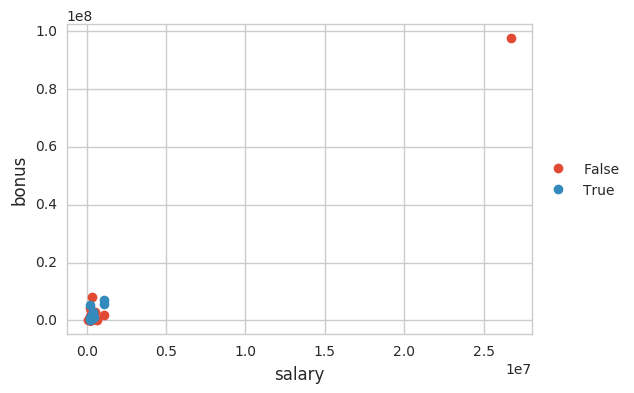

In [255]:
groups = e.groupby('poi')
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['salary'], group['bonus'], marker='o', linestyle='', label=name)
    plt.xlabel('salary')
    plt.ylabel('bonus')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
plt.show()

In [256]:
e[e == 'NaN'] = np.nan
e = e.fillna(0)
e[(e.salary > 2.5e7) & (e.bonus > 0.8e8)]
e = e.drop('TOTAL')

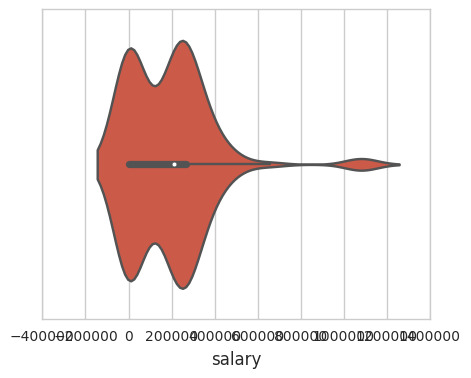

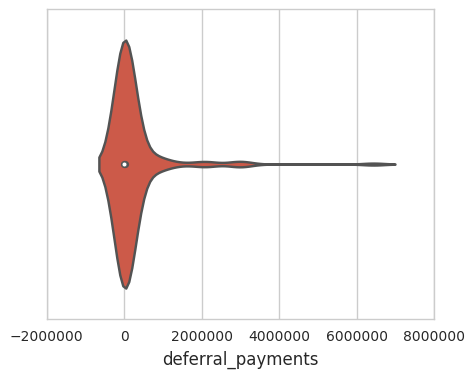

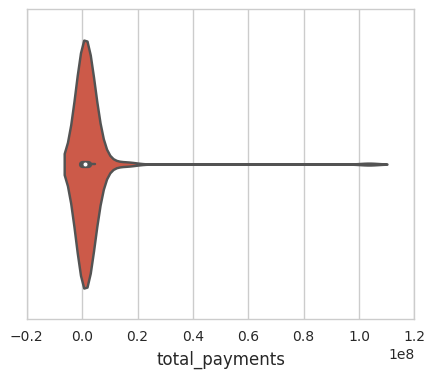

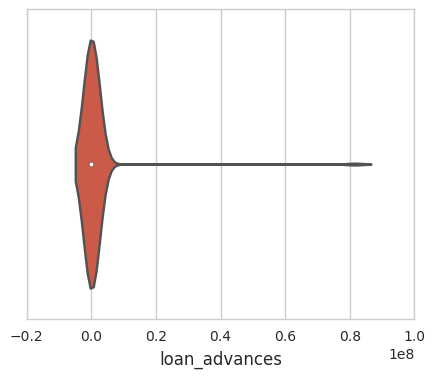

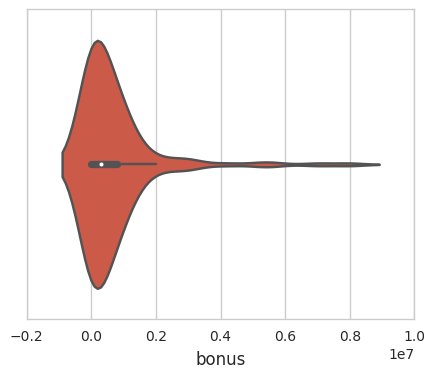

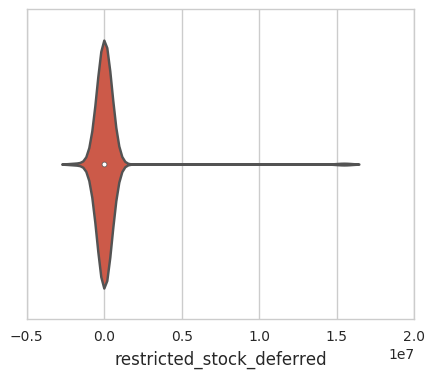

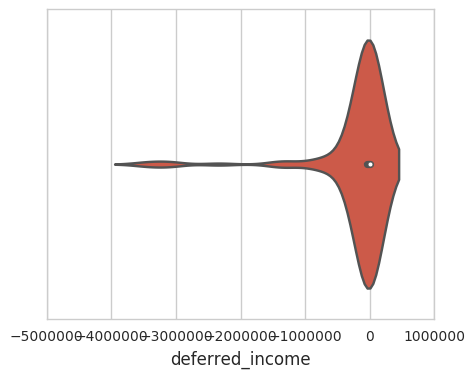

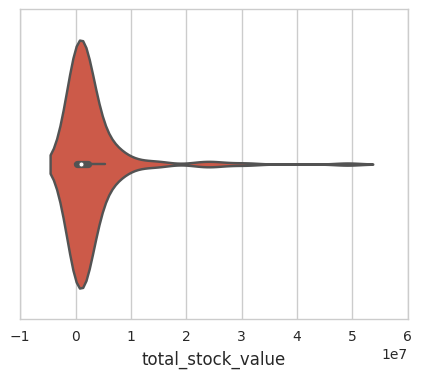

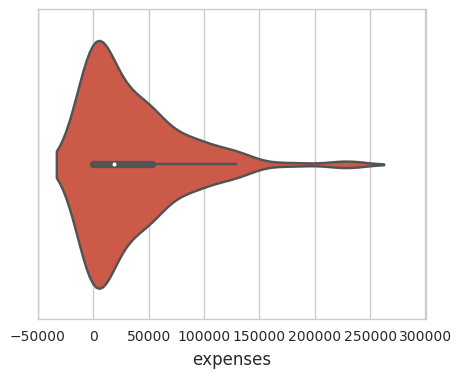

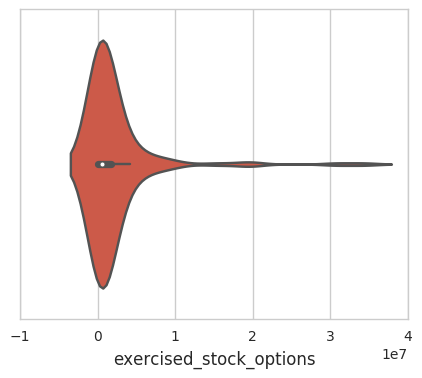

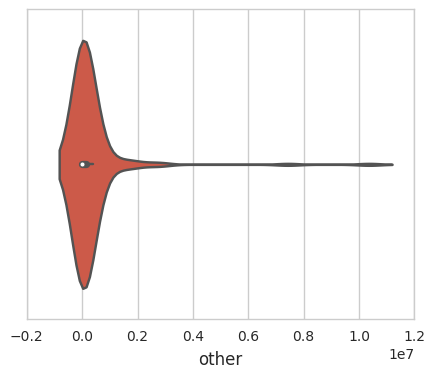

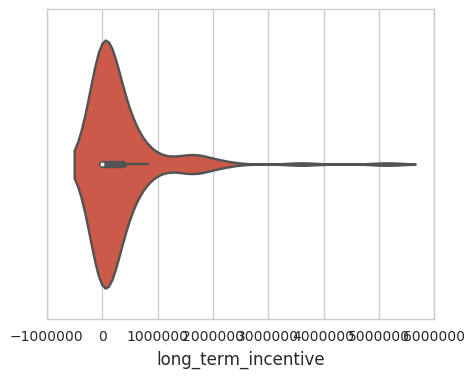

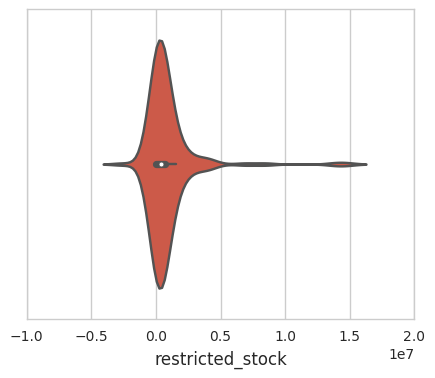

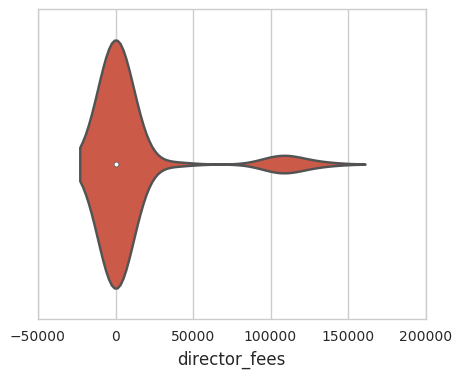

In [259]:
import seaborn as sns
sns.set_style("whitegrid")
for feature in financial_features:
    ax = plt.subplots(figsize=(5,4))
    ax = sns.violinplot(e[feature])

In [260]:
e[e.total_stock_value < 0]

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
BELFER ROBERT,0,-102500,0,3285,0,3285,0,0,0,0,...,0,0,False,0,44093,0,0,0,102500,-44093


In [261]:
# outlier
e.drop("BELFER ROBERT")

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000,2869717,-3081055,0,phillip.allen@enron.com,1729541,13868,2195,47,65,...,304805,152,False,126027,-126027,201955,1407,2902,4484442,1729541
BADUM JAMES P,0,178980,0,0,0,257817,3486,0,0,0,...,0,0,False,0,0,0,0,0,182466,257817
BANNANTINE JAMES M,0,0,-5104,0,james.bannantine@enron.com,4046157,56301,29,39,0,...,0,864523,False,1757552,-560222,477,465,566,916197,5243487
BAXTER JOHN C,1200000,1295738,-1386055,0,0,6680544,11200,0,0,0,...,1586055,2660303,False,3942714,0,267102,0,0,5634343,10623258
BAY FRANKLIN R,400000,260455,-201641,0,frank.bay@enron.com,0,129142,0,0,0,...,0,69,False,145796,-82782,239671,0,0,827696,63014
BAZELIDES PHILIP J,0,684694,0,0,0,1599641,0,0,0,0,...,93750,874,False,0,0,80818,0,0,860136,1599641
BECK SALLY W,700000,0,0,0,sally.beck@enron.com,0,37172,4343,144,386,...,0,566,False,126027,0,231330,2639,7315,969068,126027
BELDEN TIMOTHY N,5249999,2144013,-2334434,0,tim.belden@enron.com,953136,17355,484,228,108,...,0,210698,True,157569,0,213999,5521,7991,5501630,1110705
BERBERIAN DAVID,0,0,0,0,david.berberian@enron.com,1624396,11892,0,0,0,...,0,0,False,869220,0,216582,0,0,228474,2493616
BERGSIEKER RICHARD P,250000,0,-485813,0,rick.bergsieker@enron.com,0,59175,59,4,0,...,180250,427316,False,659249,0,187922,233,383,618850,659249


In [264]:
#outlier
e.drop('BANNANTINE JAMES M')

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000,2869717,-3081055,0,phillip.allen@enron.com,1729541,13868,2195,47,65,...,304805,152,False,126027,-126027,201955,1407,2902,4484442,1729541
BADUM JAMES P,0,178980,0,0,0,257817,3486,0,0,0,...,0,0,False,0,0,0,0,0,182466,257817
BAXTER JOHN C,1200000,1295738,-1386055,0,0,6680544,11200,0,0,0,...,1586055,2660303,False,3942714,0,267102,0,0,5634343,10623258
BAY FRANKLIN R,400000,260455,-201641,0,frank.bay@enron.com,0,129142,0,0,0,...,0,69,False,145796,-82782,239671,0,0,827696,63014
BAZELIDES PHILIP J,0,684694,0,0,0,1599641,0,0,0,0,...,93750,874,False,0,0,80818,0,0,860136,1599641
BECK SALLY W,700000,0,0,0,sally.beck@enron.com,0,37172,4343,144,386,...,0,566,False,126027,0,231330,2639,7315,969068,126027
BELDEN TIMOTHY N,5249999,2144013,-2334434,0,tim.belden@enron.com,953136,17355,484,228,108,...,0,210698,True,157569,0,213999,5521,7991,5501630,1110705
BELFER ROBERT,0,-102500,0,3285,0,3285,0,0,0,0,...,0,0,False,0,44093,0,0,0,102500,-44093
BERBERIAN DAVID,0,0,0,0,david.berberian@enron.com,1624396,11892,0,0,0,...,0,0,False,869220,0,216582,0,0,228474,2493616
BERGSIEKER RICHARD P,250000,0,-485813,0,rick.bergsieker@enron.com,0,59175,59,4,0,...,180250,427316,False,659249,0,187922,233,383,618850,659249


### 3. First Feature Selection 
Enron data set is a small data set with only 146 entries and have a certain amount of missing values in each feature. So I perform two steps to firstly narrow down the feature list.

  - abandon features with more missing values
  - perform SelectKbest algorithm to select 50% of features that are more sensitive to poi

Features with lot of missing values have no valuable information for future model training. So, I firstly calculate the occurence of missing values in each features and features with  more missing values(>70) will immediately be thrown away. Then, I find out my firstly selected features: 'total_stock_value', 'total_payments', 'restricted_stock', 'exercised_stock_options', 'salary', 'expenses', 'other', 'to_messages', 'shared_receipt_with_poi', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'bonus'.

However, this might lead to some problem of losing important information if some feature is very sensitive to person of interest. So, I calcalate the ratio of valid values in abandoned features according to each poi class and find out two features (long_term_incentive and deferred_income) are maybe useful for future feature engineering. long_term_incentive has 12 valid values in a total of 18 true poi and deferred_income has 11 valid values in a total of 18 true poi. If the selected features are not powerful enough to build a model, I will consider to add these two features.


#### 3.1 Abandon features with more missing values  
Features with lot of missing values have no valuable information for future model training. So, I firstly calculate the occurence of missing values, 0 imputed for NA, 
in each features and features with  more missing values(>70) will immediately be thrown away. Then, I find out my firstly selected features: 'total_stock_value', 'total_payments', 'restricted_stock', 'exercised_stock_options', 'salary', 'expenses', 'other', 'to_messages', 'shared_receipt_with_poi', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'bonus'.

However, this might lead to some problem of losing important information if some feature is very sensitive to person of interest. So, I calcalate the ratio of valid values in abandoned features according to each poi class and find out two features (long_term_incentive and deferred_income) are maybe useful for future feature engineering. long_term_incentive has 12 valid values in a total of 18 true poi and deferred_income has 11 valid values in a total of 18 true poi. If the selected features are not powerful enough to build a model, I will consider to add these two features.

C:\Users\lavender\Anaconda2\envs\udacity\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: order is deprecated, use sort_values(...)
  app.launch_new_instance()


poi                            0
total_stock_value             20
total_payments                21
email_address                 35
restricted_stock              36
exercised_stock_options       44
salary                        51
expenses                      51
other                         53
to_messages                   60
shared_receipt_with_poi       60
from_messages                 60
from_poi_to_this_person       60
from_this_person_to_poi       60
bonus                         64
long_term_incentive           80
deferred_income               97
deferral_payments            107
restricted_stock_deferred    128
director_fees                129
loan_advances                142
dtype: int64


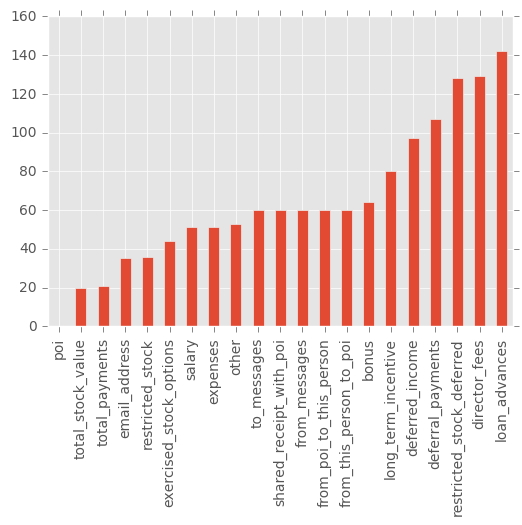

In [83]:
# Number of NaN for each feature
e[e == 'NaN'] = np.nan
na_num = e.isnull().sum().order()
print na_num
na_num.plot(kind = 'bar')


In [85]:
# number of true "poi" and number of false "poi" in data set
e.poi.value_counts()#.plot(kind = 'bar', width=0.35)

False    127
True      18
Name: poi, dtype: int64

In [192]:
# features that have the number of missing values(NA) less than 70 
# will be selected to further feature selection
my_feature = na_num[na_num<70]
my_feature = list(my_feature.index)
print my_feature
print len(my_feature)

['poi', 'total_stock_value', 'total_payments', 'email_address', 'restricted_stock', 'exercised_stock_options', 'salary', 'expenses', 'other', 'to_messages', 'shared_receipt_with_poi', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'bonus']
15


In [87]:
# abandoned features(counts of missing value more than 70) and the counts of missing values in each class
# for example, there are 53 entries have valid long_term_incentive feature values with Falss "poi"
# and 12 entries have valid long_term_incentive feature values with True "poi"
aban_feature = na_num[na_num>70]
aban_feature = list(aban_feature.index)
false_ratio = e[aban_feature + ['poi']].groupby('poi').count()
false_ratio

,long_term_incentive,deferred_income,deferral_payments,restricted_stock_deferred,director_fees,loan_advances
poi,,,,,,
False,53,37,33,17,16,2
True,12,11,5,0,0,1


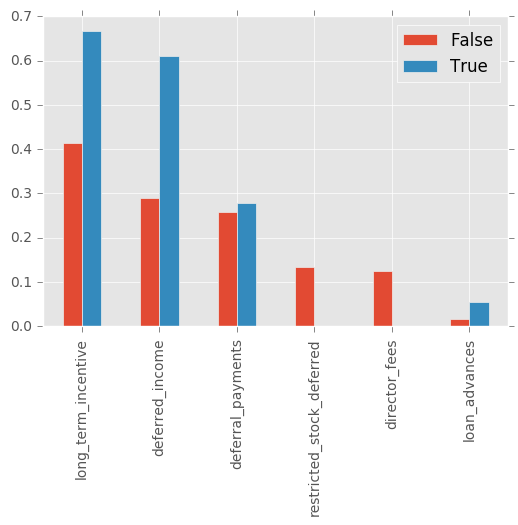

In [88]:
# the ratio of valid values in abandon faeatures according to each poi class
# calculated by previous table
false_ratio = e[aban_feature + ['poi']].groupby('poi').count().iloc[0,:]/128
true_ratio = e[aban_feature + ['poi']].groupby('poi').count().iloc[1,:]/18
ratio_df = pd.DataFrame({'False':false_ratio, 'True':true_ratio})
ratio_df.plot(kind='bar')

In [89]:
ratio_df

,False,True
long_term_incentive,0.414062,0.666667
deferred_income,0.289062,0.611111
deferral_payments,0.257812,0.277778
restricted_stock_deferred,0.132812,0.000000
director_fees,0.125000,0.000000
loan_advances,0.015625,0.055556


#### 3.2 SelectKbest Algorithm
At this point, the size of feature list is decreased to 14. It is still too much for building a intuitive model. So I apply  [SelectKbest](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) algorithm for further feature selection. As a result, 'total_stock_value', 'salary', 'expenses', 'bonus', and 'shared_receipt_with_poi' are most relevant features to the poi.


In [271]:
my_feature = ['poi', 'total_stock_value',
              'salary', 'expenses',
              'other', 'to_messages', 'shared_receipt_with_poi', 'from_messages',
              'from_poi_to_this_person', 'from_this_person_to_poi', 'bonus']
data_dict.pop('TOTAL')
data_dict.pop('BELFER ROBERT')
data_dict.pop('BANNANTINE JAMES M')
### Store to my_dataset for easy export below.
my_dataset = data_dict
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, my_feature, sort_keys = True)
labels, features = targetFeatureSplit(data)
# feature scale first
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_features = scaler.fit_transform(features)
#use SelectPercentile to improve feature selection
from sklearn.feature_selection import SelectPercentile, f_classif
selector = SelectPercentile(f_classif, percentile=50)
selector.fit(scale_features, labels)
SP_features = []
for e in range(len(selector.get_support())):
    if  selector.get_support()[e] == True:
        SP_features.append(my_feature[1:][e])
print "SelectPercentile features: ", SP_features

KeyError: 'TOTAL'

### 4 Predictive Modeling 
The goal our this project is to build a predictive model that has a power of more then 0.3 for both recall and precision. For supervised classification algorithms, each algorithm has its strength in different situation and patterns. So, I start with making scatterplot between each features to figure out if certain patterns existed and then select desirable model candidates to perform model selection based on the plots




#### 4.1 Scatterplot
Features scatterplot is straigtforwad and convenient to detect patterns for small data set. However, features in Enron data set has different scale. So when I make scatterplot based on original data set, the scatterplot looks clumsy and most of points crowed to the corner, which is very hard to see the distribution of the person of interest. Then I apply logrithmic transforamtion for each disrable features and it looks much better. All the scatterplots after transformation see blue points(true poi) are entangled with red points(false poi). In this situation, algorithms like decision tree, knearest neighbours, and naive bayes are better to use. Support vector machine is powerful, but might not be a good choice in this case where amounts noise existed and no clear boundary detected. So our model candidates are Decision Tree, Knearest Neighbours and Naive Bayes.

In regarding to PCA, PCA is a good tool to solve the problem of correlation between each features. In this data, I cannot see some clear patterns in the scatterplots. And considering machine learning for financial data set, model explanation is more intuitive and important the  the model accuracy. As a result, PCA is not applied for building models.


In [115]:
selected_feature = ['total_stock_value', 'salary', 'expenses', 'bonus', 'shared_receipt_with_poi']
selected_e = e[['poi']+selected_feature]

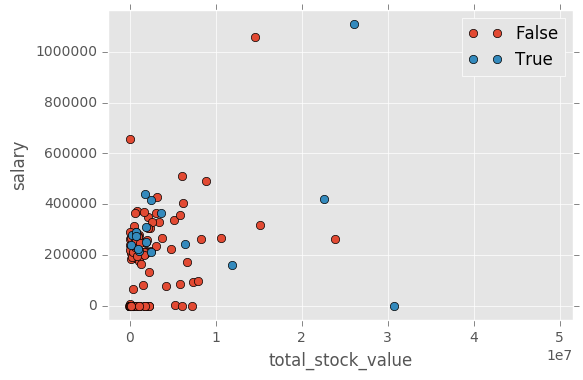

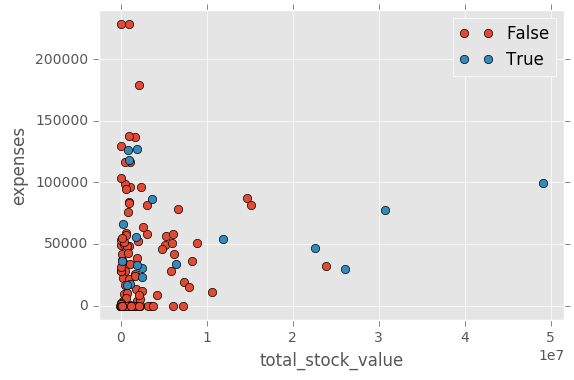

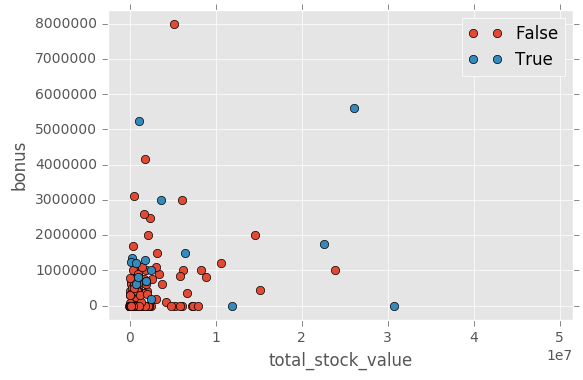

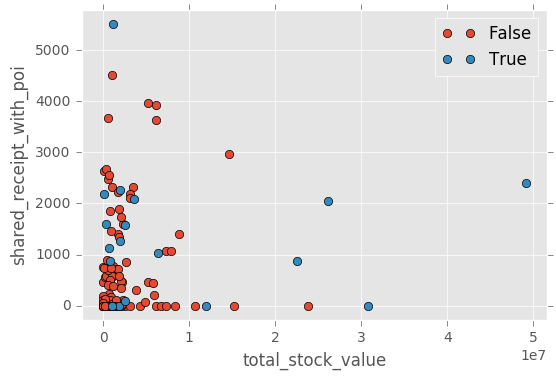

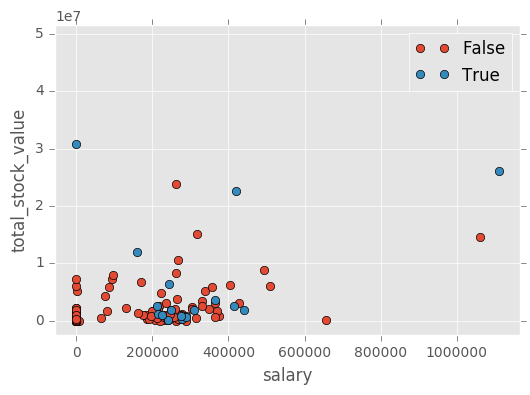

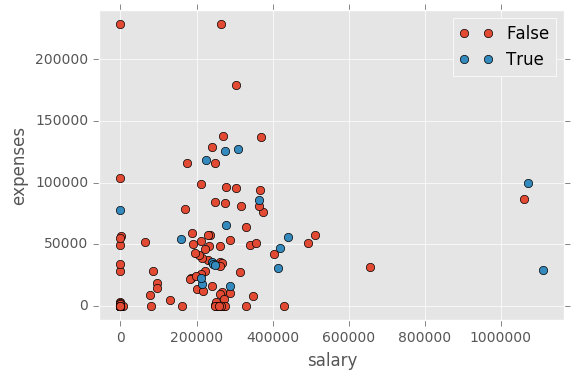

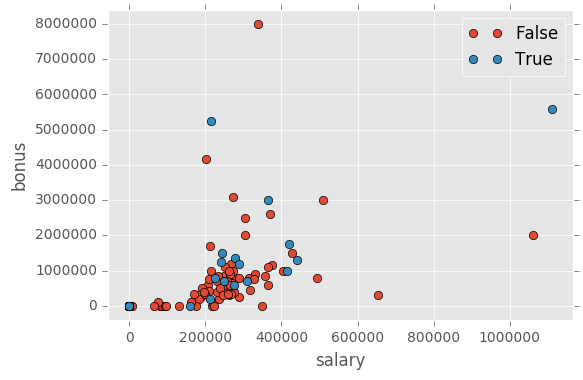

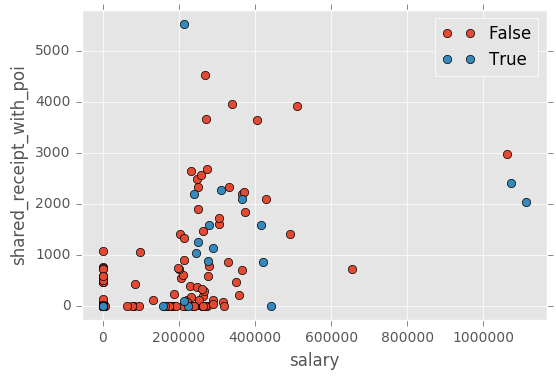

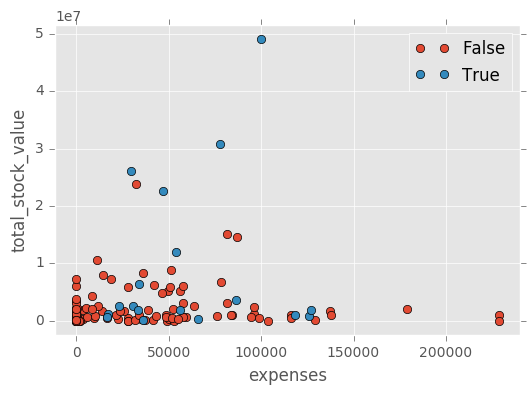

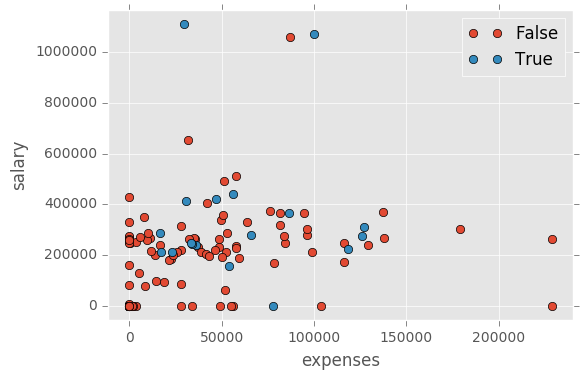

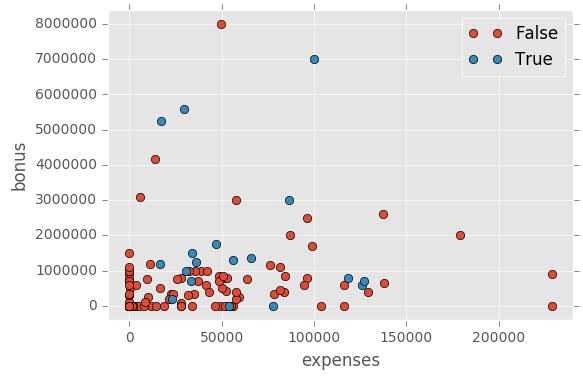

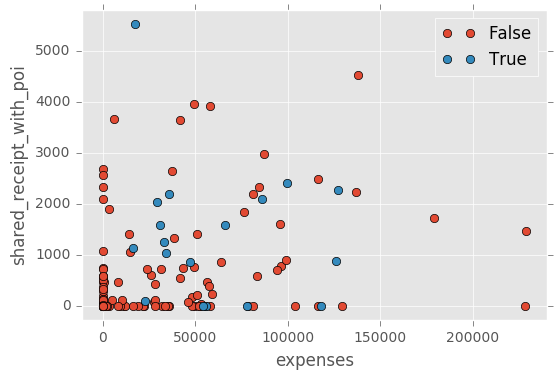

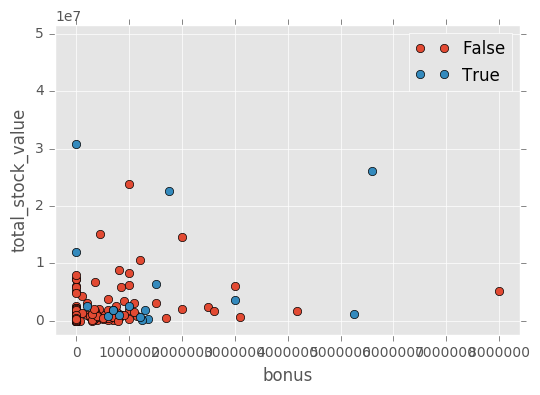

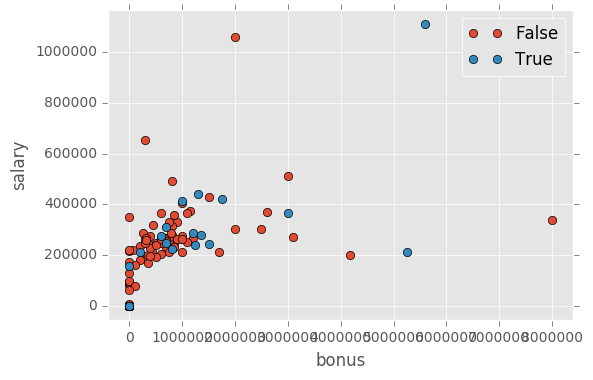

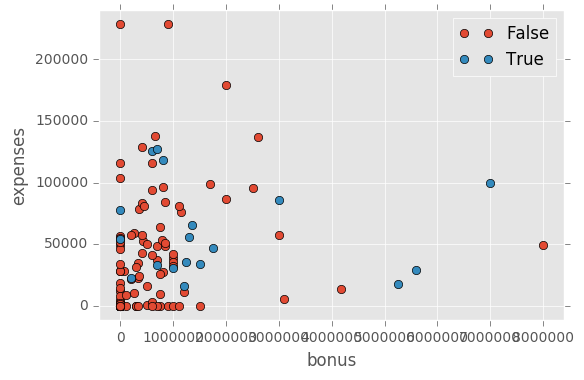

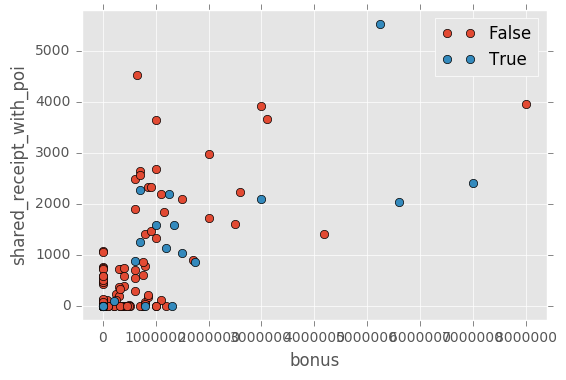

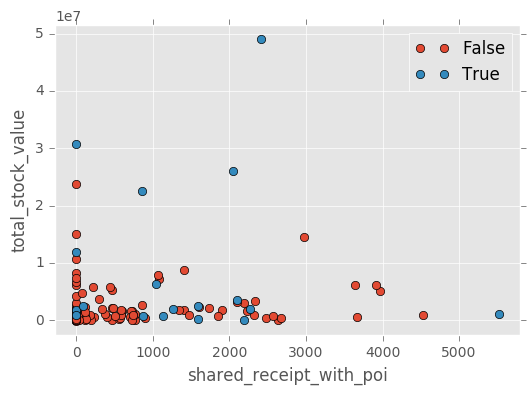

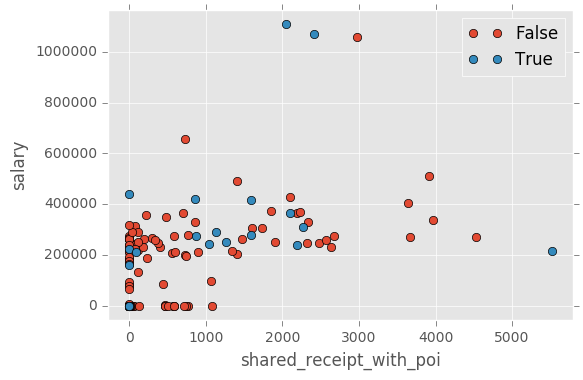

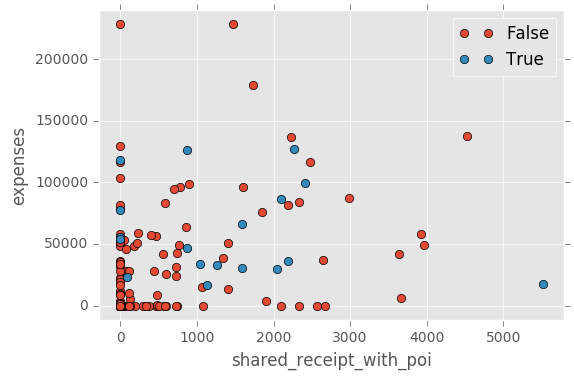

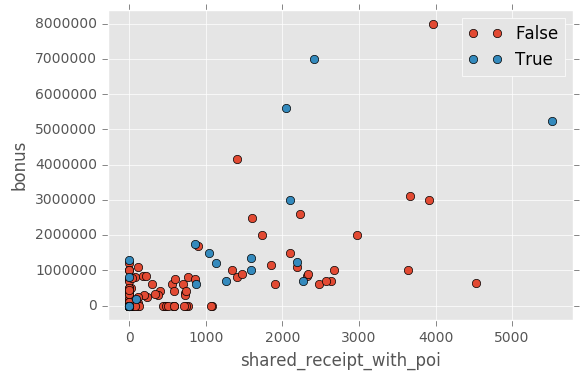

In [118]:
# scatterplot for features group by 'poi
groups = selected_e.groupby('poi')
for x in selected_feature:
    for y in selected_feature:
        if y == x:
            continue     
        fig, ax = plt.subplots()
        ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
        for name, group in groups:
            ax.plot(group[x], group[y], marker='o', linestyle='', label=name)
            plt.xlabel(x)
            plt.ylabel(y)
        ax.legend()
        plt.show()


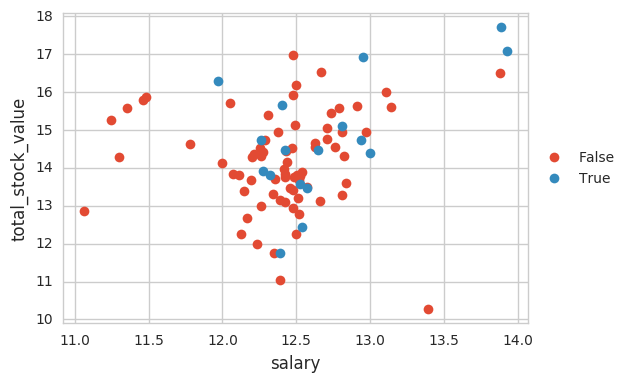

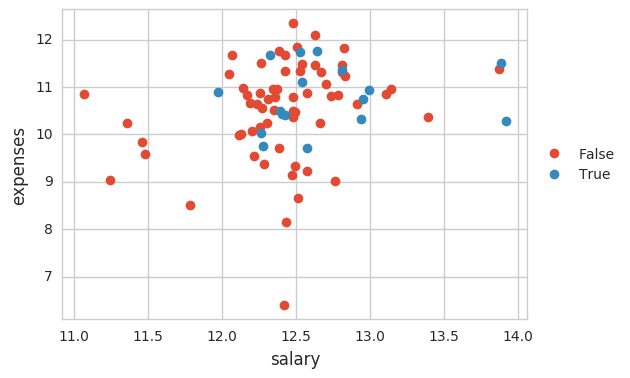

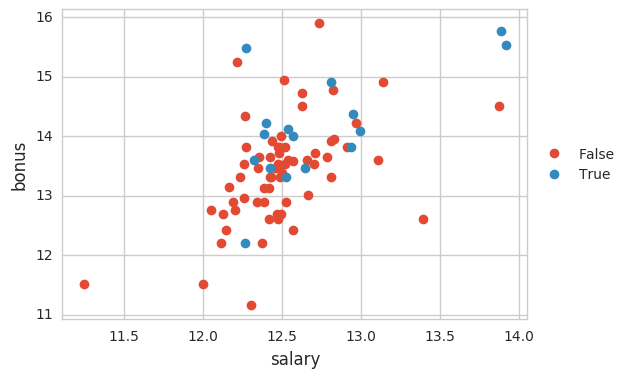

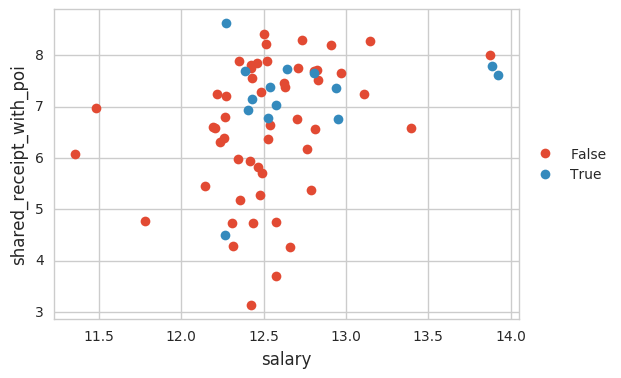

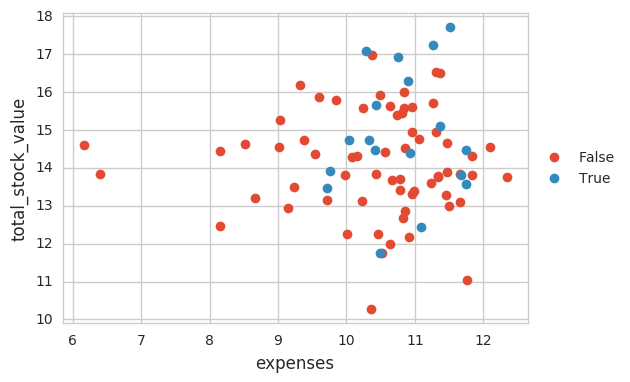

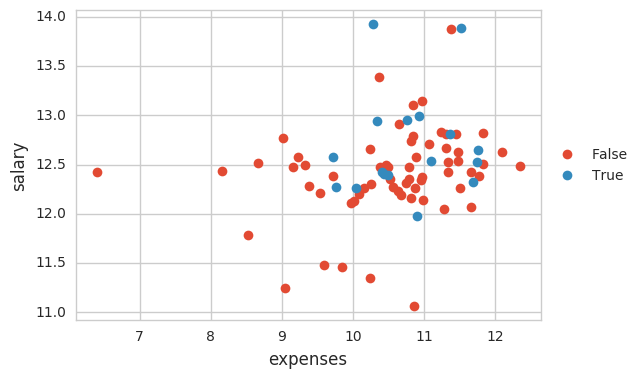

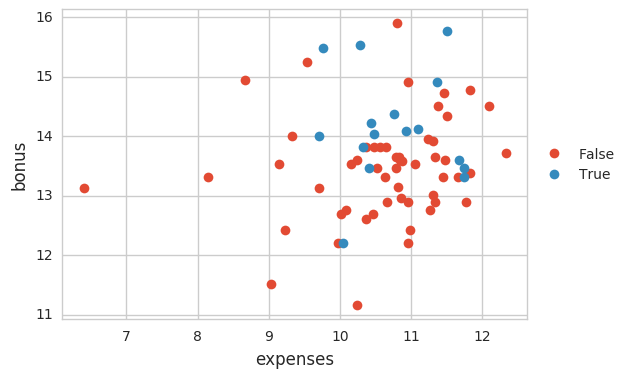

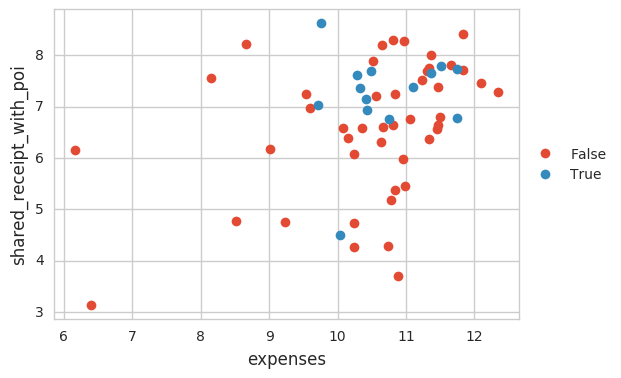

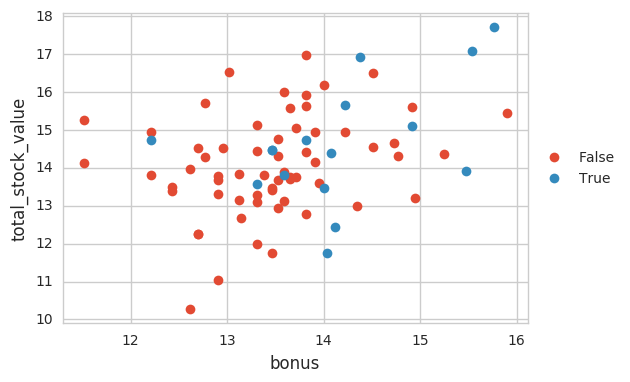

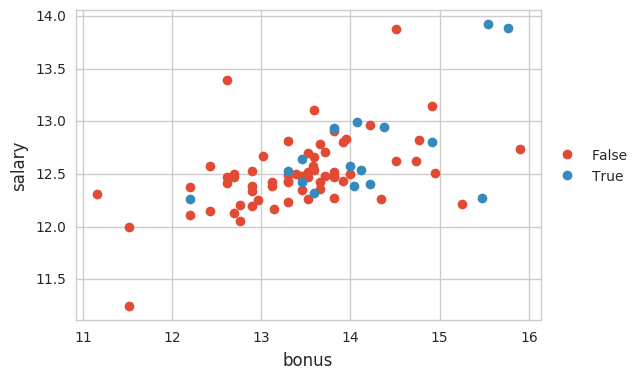

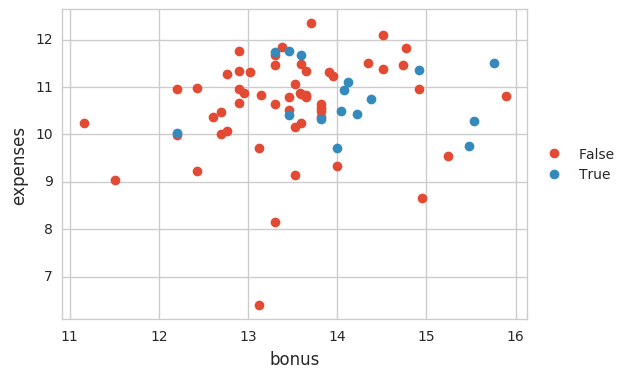

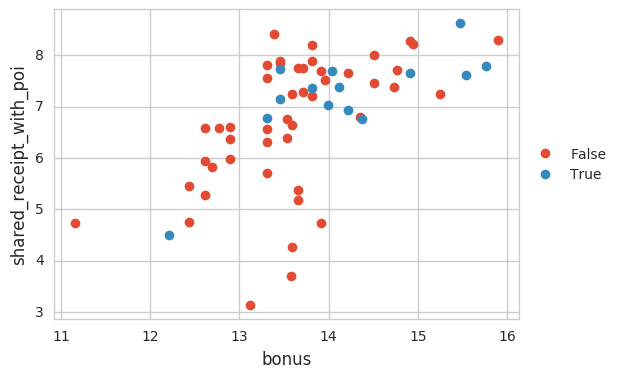

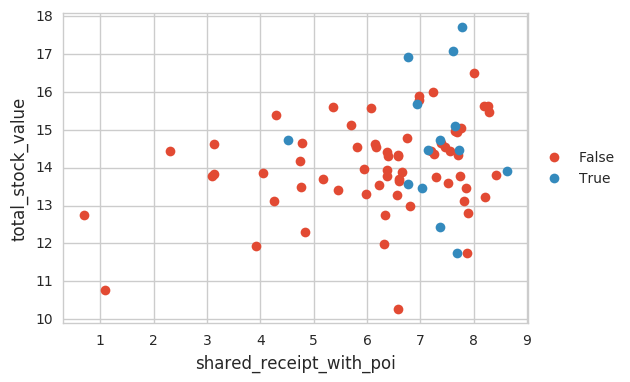

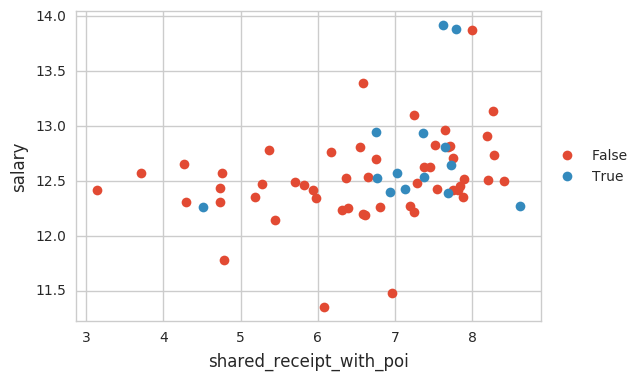

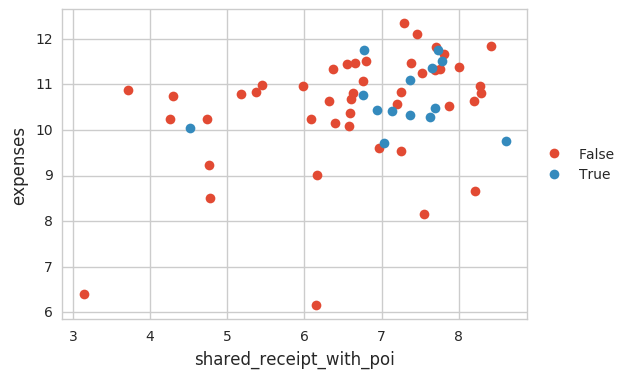

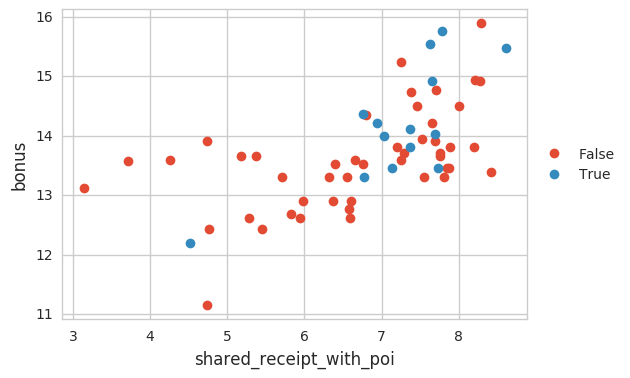

In [268]:
# scatterplot for selected features group by 'poi with logorithmic transformation
selected_e=selected_e.fillna(0)
groups = selected_e.groupby('poi')
for x in selected_feature[1:]:
    for y in selected_feature:
        if y == x:
            continue     
        fig, ax = plt.subplots()
        ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
        for name, group in groups:
            ax.plot(np.log(group[x]), np.log(group[y]), marker='o', linestyle='', label=name)
            plt.xlabel(x)
            plt.ylabel(y)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()


C:\Users\lavender\Anaconda2\envs\udacity\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


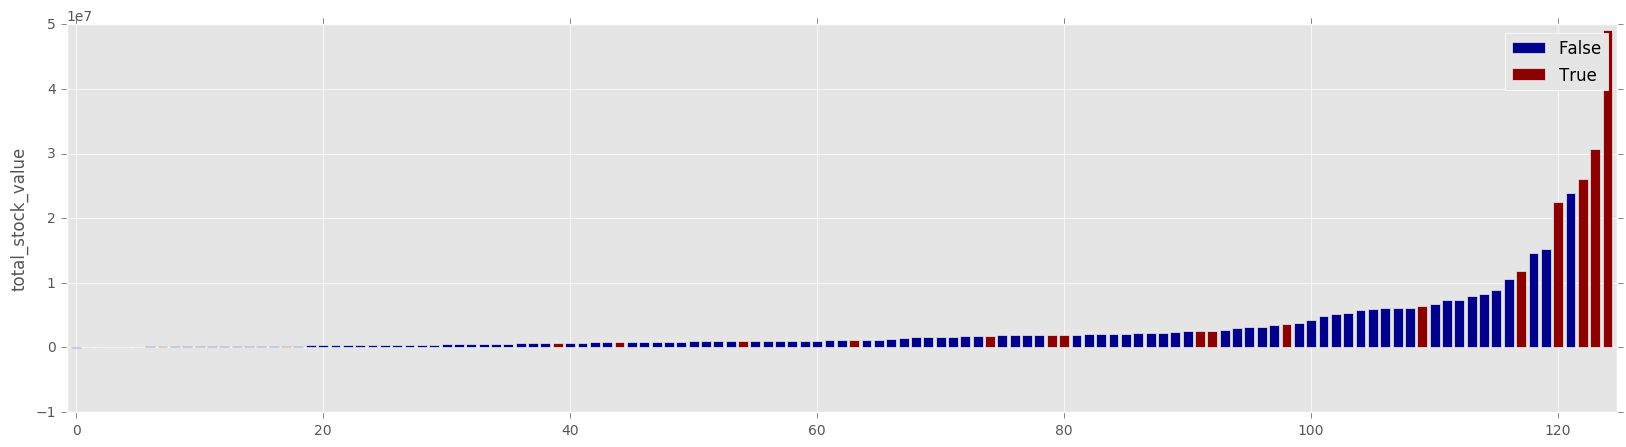

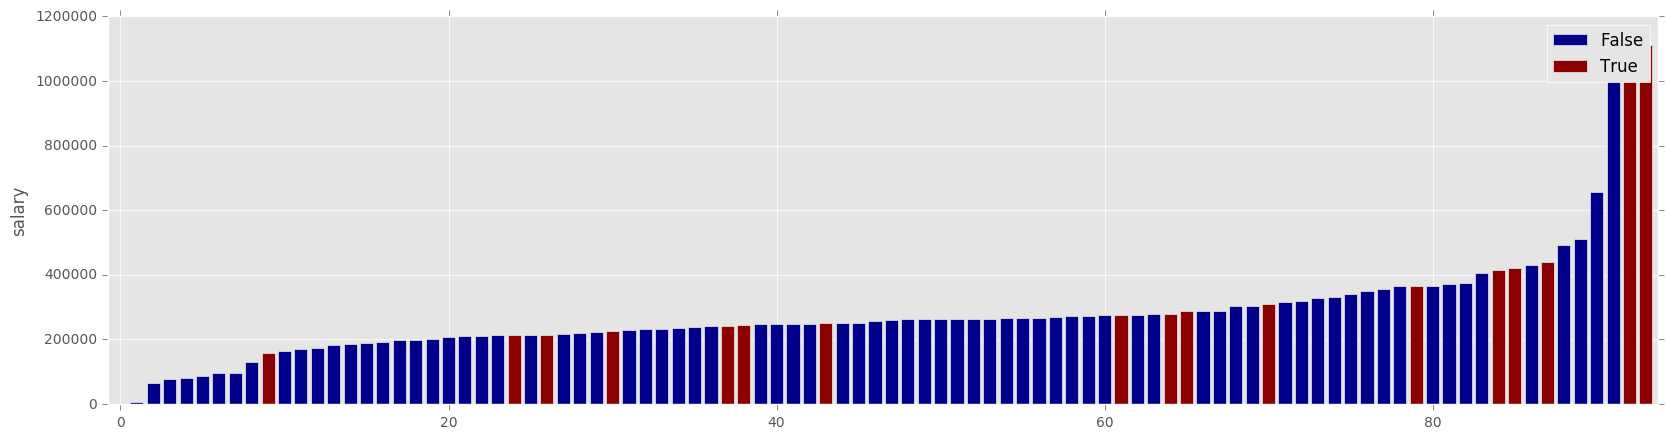

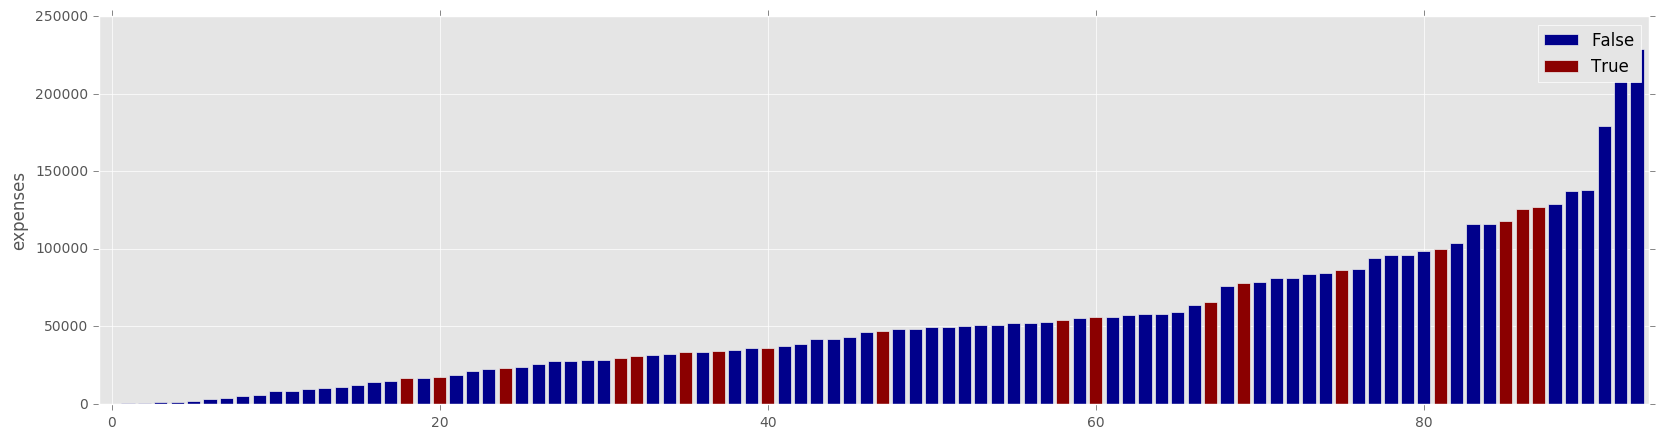

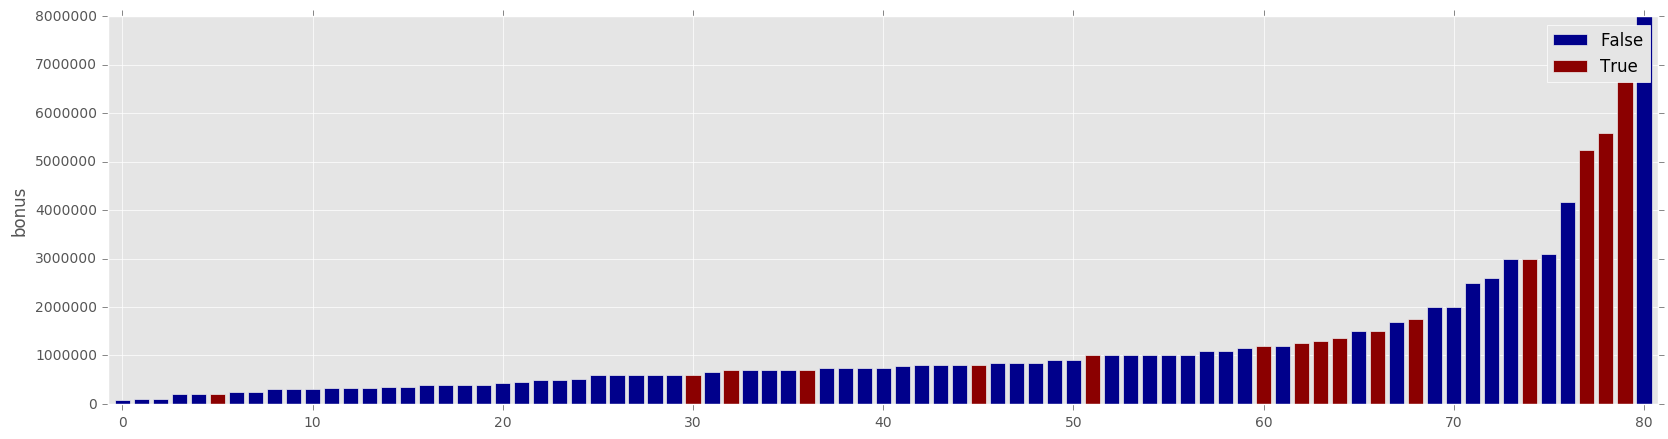

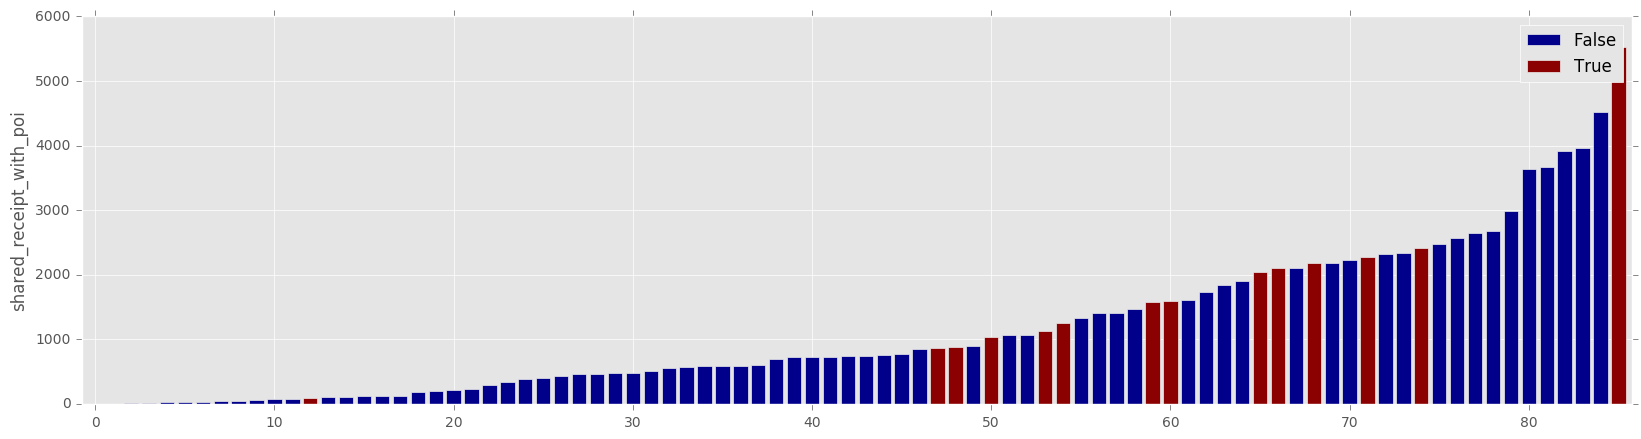

In [111]:
# after runing SelectKbest, I got a list of selected_feature for future machine learning 
selected_feature = ['total_stock_value', 'salary', 'expenses', 'bonus', 'shared_receipt_with_poi']
for feature in selected_feature:
    plt_bar = e[[feature ,'poi']].dropna().sort(feature).reset_index()
    fig, ax = plt.subplots(figsize=(20,5))
    false_data = plt_bar[plt_bar.poi == False][feature]
    true_data = plt_bar[plt_bar.poi == True][feature]
    ax.bar(false_data.index,false_data, label='False',color='DarkBlue',align='center')
    ax.bar(true_data.index,true_data, label='True',color="DarkRed",align='center')
    #true_data.plot(kind='bar',label='False',color="DarkGreen")
    
    ax.set_xlim(left=plt_bar.index[0]-0.75,right=plt_bar.index[-1]+0.75)
    ax.set_ylabel(feature)
    ax.legend()

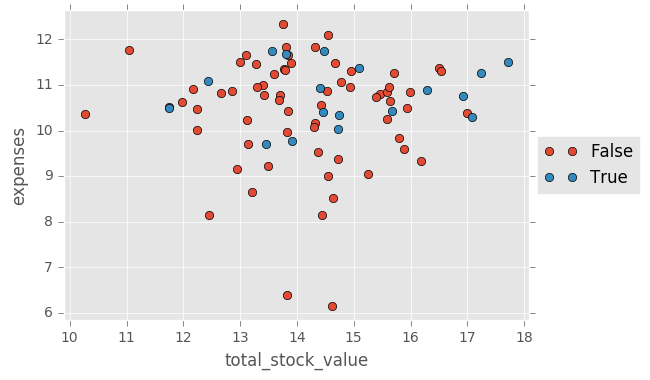

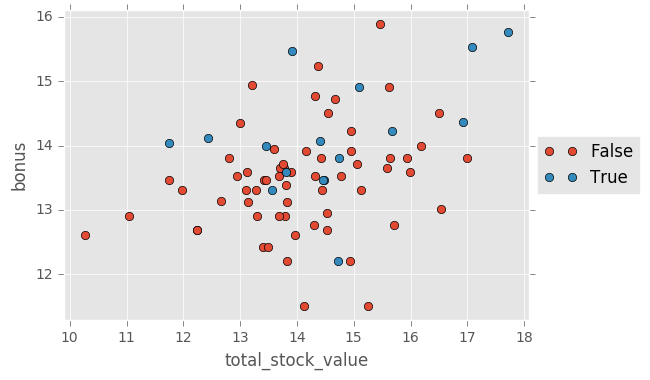

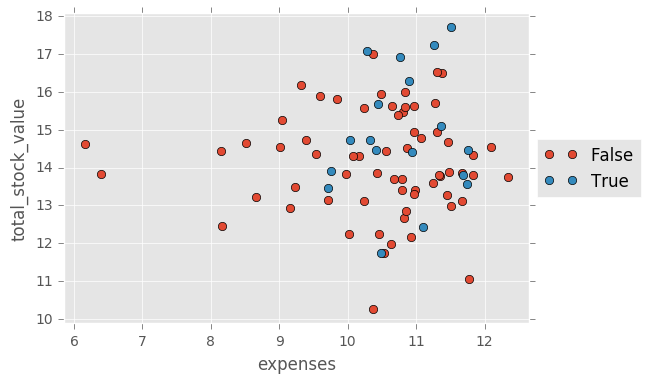

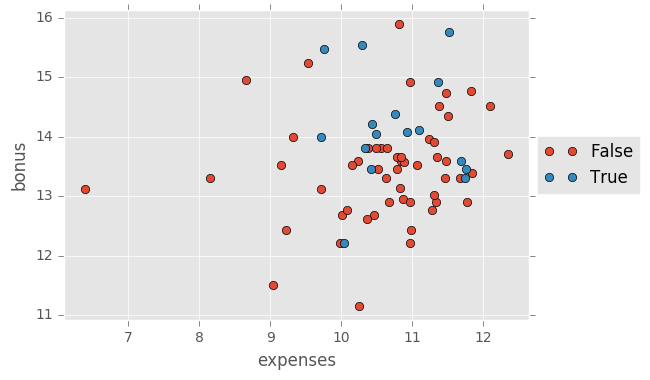

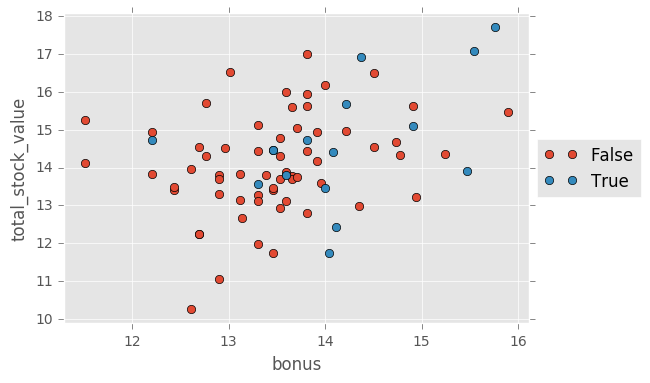

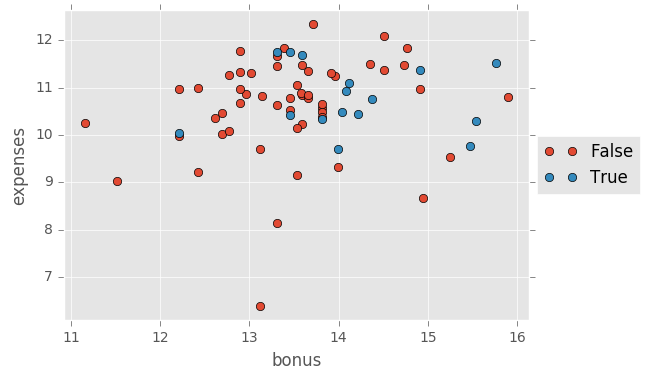

In [151]:
# final features scatterplot 
final_feature = ['total_stock_value', 'expenses', 'bonus']
groups = selected_e.groupby('poi')
for x in final_feature:
    for y in final_feature:
        if y == x:
            continue     
        fig, ax = plt.subplots()
        ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
        for name, group in groups:
            ax.plot(np.log(group[x]), np.log(group[y]), marker='o', linestyle='', label=name)
            plt.xlabel(x)
            plt.ylabel(y)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

#### 4.2 Decision Tree
Decision tree is a algorithm that is simple to understand and interpret which is a good choice for this financial senario. When training the tree, it is also a good method to see which feature has more importance in predicting label, which makes it anonther way to further selection. First, I train the tree with five desirable features and get coresponding feature importance:
 - 'total_stock_value': 0.18
 - 'salary': 0.12
 - 'expenses : '0.41
 - 'shared_receipt_with_poi' : 0.10
 - 'bonus' : 0.19

It is clear that feature 'shared_receipt_with_poi' and 'salary' are the least two important factor. So, I skip these two features and retrain the model ending with more desirable result:
 - Precision: 0.36 --> 0.59
 - Recall: 0.40 --> 0.50

In this way, I finalize my three preferred features : 'total_stock_value', 'expenses', 'bonus' 


#### 5 Predictive Modeling 
Decision Tree get a good result in feature selection phase. Two more methods will applied in order to find the most powerful model. All the hyper-parameters tuning is optimized by Gridsearch. The test result as follow :
 - Naive Bayes with Gaussian : Precision: 0.54 Recall: 0.35
 - Knearest Neighbour : Precision: 0.33   Recall: 0.15

Based on the result of different model, Decision Tree has the strongeset predictive power with a precision of 0.59 and a recall of 0.50. That means if the model predicts a new sample as person of interest, its accuracy is nearly 60% right.


In [ ]:
# Run all the models
%run poi_id.py

In [284]:
# model recall and precision for each models
%run tester.py

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=2, max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')
	Accuracy: 0.87857	Precision: 0.58824	Recall: 0.50000	F1: 0.54054	F2: 0.51546
	Total predictions:  140	True positives:   10	False positives:    7	False negatives:   10	True negatives:  113

GaussianNB(priors=None)
	Accuracy: 0.86429	Precision: 0.53846	Recall: 0.35000	F1: 0.42424	F2: 0.37634
	Total predictions:  140	True positives:    7	False positives:    6	False negatives:   13	True negatives:  114

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
	Accuracy: 0.83571	Precision: 0.33333	Recall: 0.15000	F1: 0.20690	F2: 0.16854
	Total predictions:  140	True positives:    

C:\Users\lavender\Anaconda2\envs\udacity\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


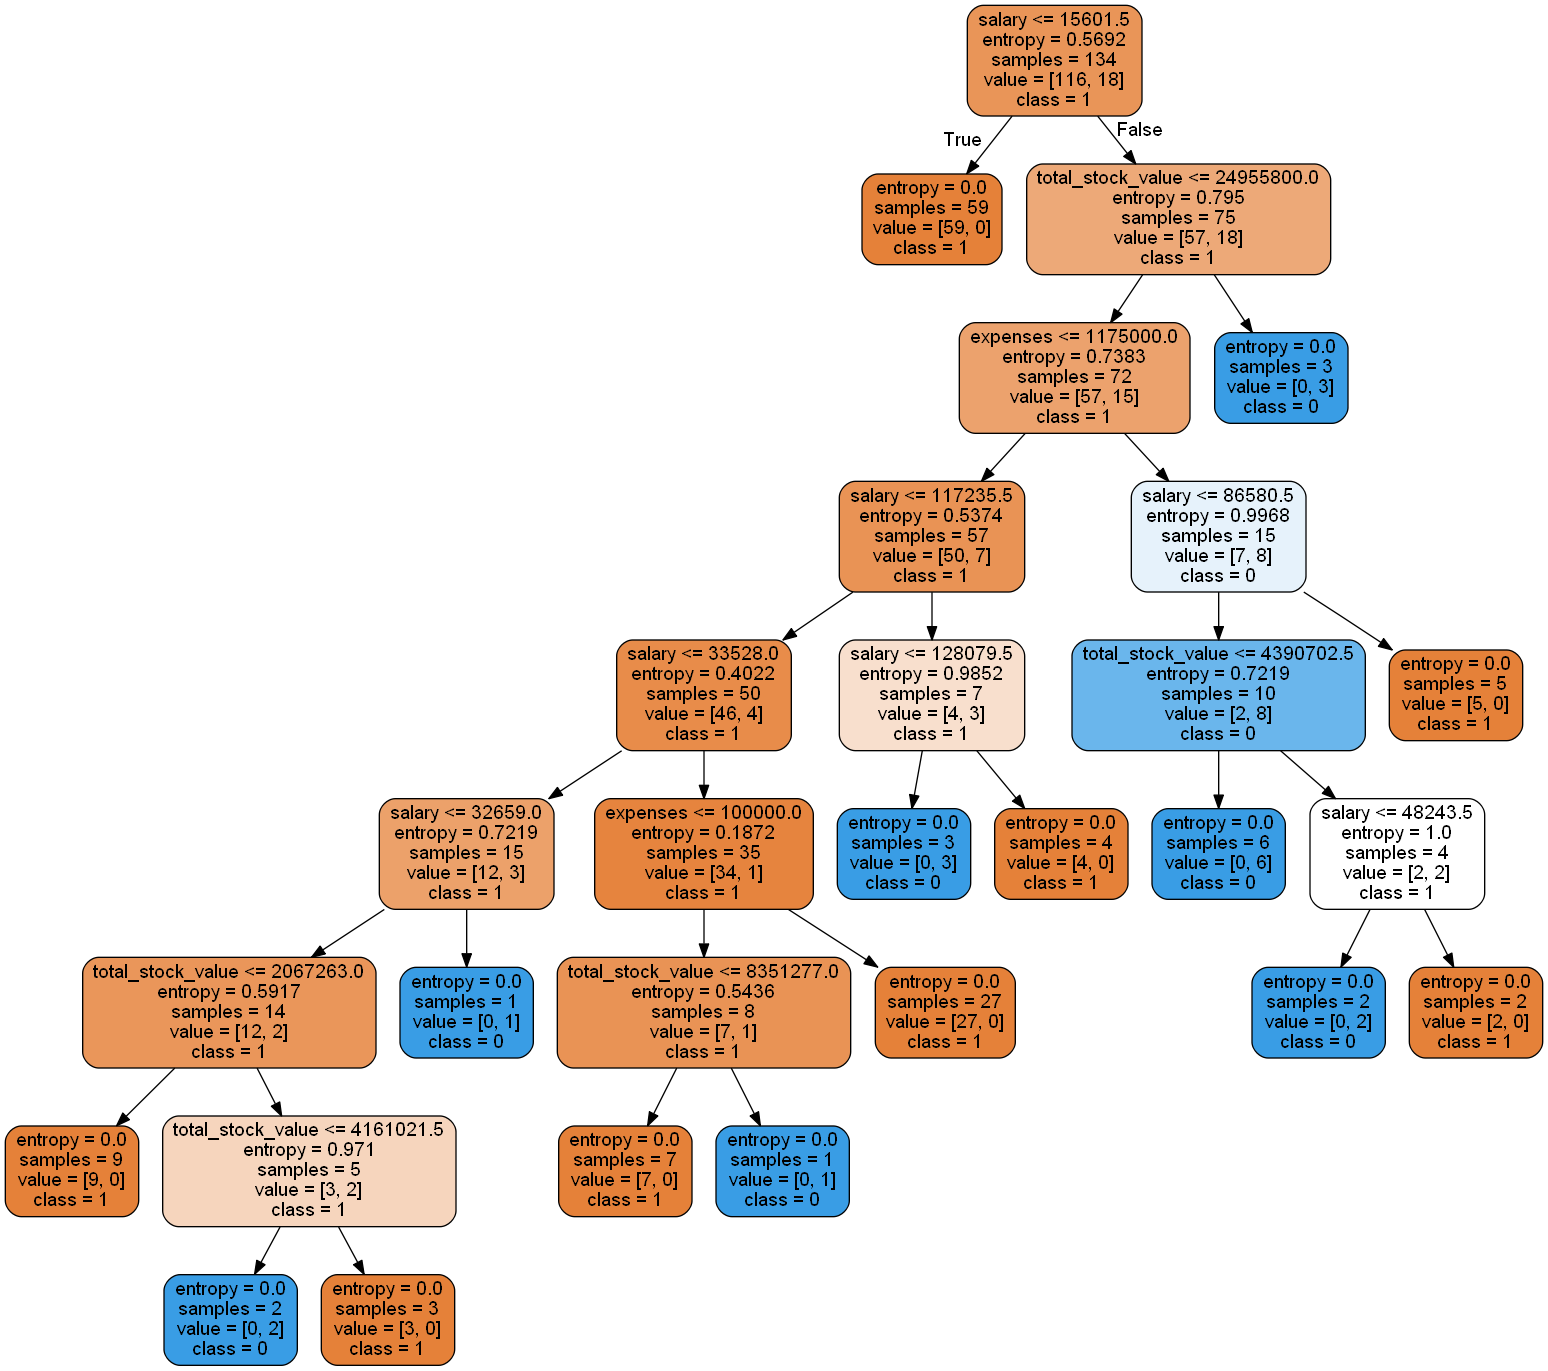

In [283]:
import pydotplus
from sklearn import tree
from IPython.display import Image
with open("tree_clf.pkl","r") as clf_file:
    tree_clf = pickle.load(clf_file)
dot_data = tree.export_graphviz(tree_clf, out_file=None,
                         feature_names=SP_features,
                         class_names=['1', '0'],
                         filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

C:\Users\lavender\Anaconda2\envs\udacity\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


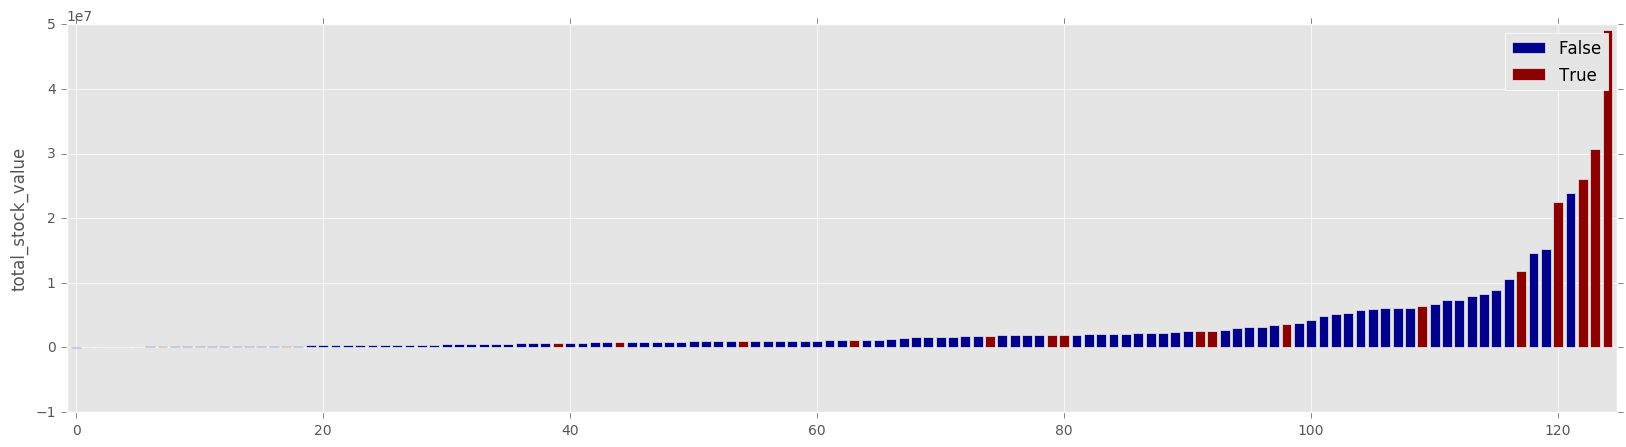

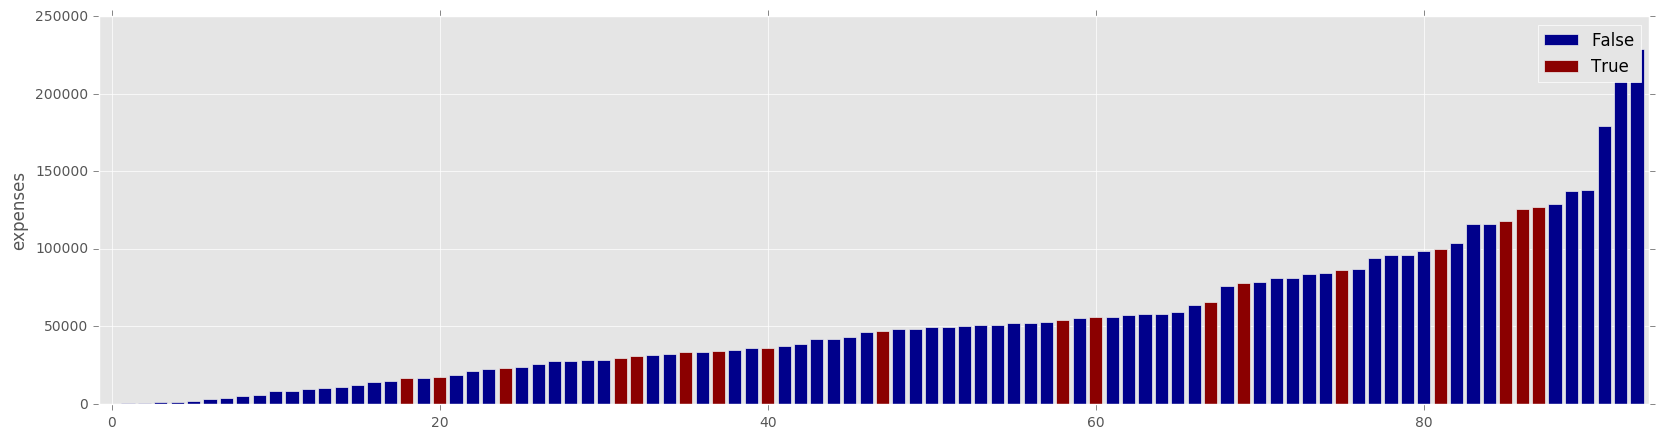

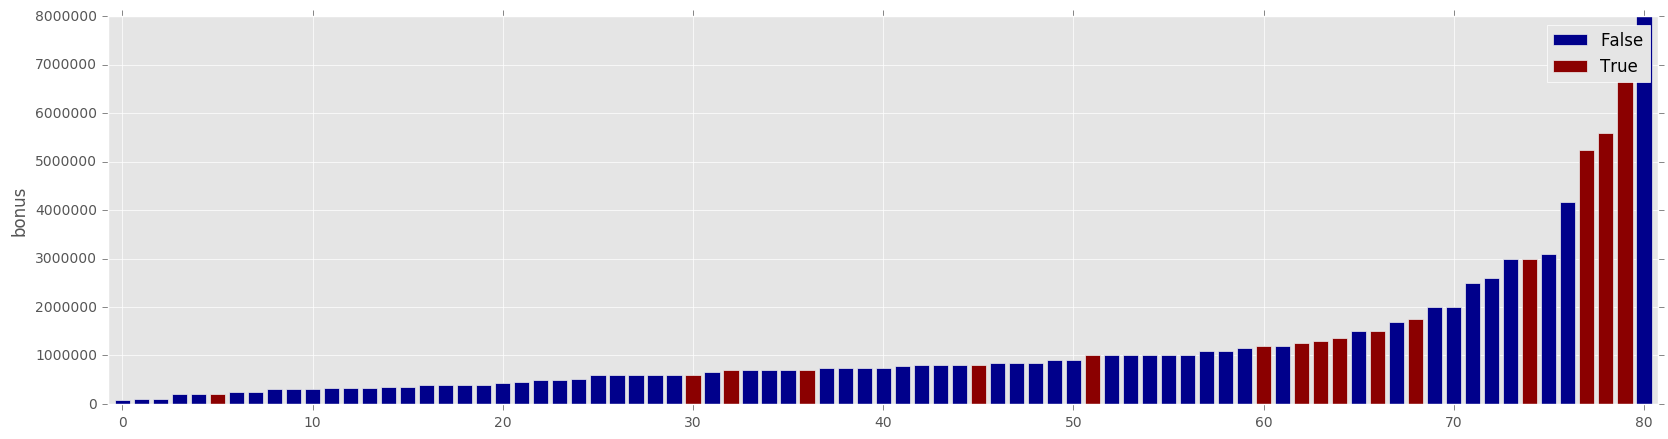

In [152]:
# barplot for final features
for feature in final_feature:
    plt_bar = e[[feature ,'poi']].dropna().sort(feature).reset_index()
    fig, ax = plt.subplots(figsize=(20,5))
    false_data = plt_bar[plt_bar.poi == False][feature]
    true_data = plt_bar[plt_bar.poi == True][feature]
    ax.bar(false_data.index,false_data, label='False',color='DarkBlue',align='center')
    ax.bar(true_data.index,true_data, label='True',color="DarkRed",align='center')
    #true_data.plot(kind='bar',label='False',color="DarkGreen")
    
    ax.set_xlim(left=plt_bar.index[0]-0.75,right=plt_bar.index[-1]+0.75)
    ax.set_ylabel(feature)
    ax.legend()